<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter16/Diffusion_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q diffusers torch-snippets

In [2]:
from torch_snippets import *
from diffusers import DDPMScheduler, UNet2DModel
from torch.utils.data import Subset

device = 'cuda' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(32),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)
# dataset = Subset(dataset, [0,1,2,3,4,5,6,7])
len(dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 161256797.28it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26391218.70it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45777564.91it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15875440.64it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



60000

Input shape:
torch.Size([8, 1, 32, 32])

Labels: tensor([0, 7, 3, 1, 4, 2, 0, 9])

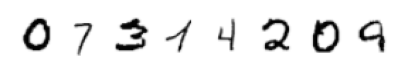

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
show(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [5]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 128, 256),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
)
_ = net.to(device)

In [6]:
for bx, (x, y) in enumerate(train_dataloader):
  break

In [7]:
pred = net.conv_in(x.to(device))
pred.shape

torch.Size([128, 32, 32, 32])

In [8]:
pred2 = net.time_embedding(pred.to(device))
pred2.shape

torch.Size([128, 32, 32, 128])

In [10]:
_ = net.to(device)

In [11]:
time_embedding_output = None

# Define the hook function
def get_time_embedding_output(module, input, output):
    global time_embedding_output
    time_embedding_output = output

# Attach the hook to the time_embedding layer
# hook = net.down_blocks[1].attentions[0].group_norm.register_forward_hook(get_time_embedding_output)

hook = net.down_blocks[1].register_forward_hook(get_time_embedding_output)

# Now, run your data through the model
# Assuming 'data' is your input tensor
_ = net(x.to(device), 78)

# Detach the hook after use
hook.remove()

# 'time_embedding_output' now contains the output of the time_embedding layer
print(time_embedding_output[1][1].shape)

torch.Size([128, 64, 8, 8])

In [12]:
# def corrupt(x, amount):
#   """Corrupt the input `x` by mixing it with noise according to `amount`"""
#   noise = torch.rand_like(x)
#   amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
#   return x*(1-amount) + noise*amount

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

def corrupt(xb, timesteps=None):
  if timesteps is None:
    timesteps = torch.randint(0, 999, (len(xb),)).long().to(device)
  noise = torch.randn_like(xb)
  noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
  return noisy_xb, timesteps

In [13]:
_ = net.to(device)

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

# The training loop

n_epochs = 1
report = Report(n_epochs)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

scheduler = CosineAnnealingLR(opt, T_max=len(train_dataloader), verbose=False)

for epoch in range(n_epochs):
    n = len(train_dataloader)
    for bx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)  # Data on the GPU
        noisy_x, timesteps = corrupt(x)  # Create our noisy x
        pred = net(noisy_x, timesteps).sample
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        report.record(epoch + ((bx + 1) / n), loss=loss.item(), end='\r')
    report.report_avgs(epoch + 1)


EPOCH: 0.156  loss: 0.045  (18.82s - 102.09s remaining)

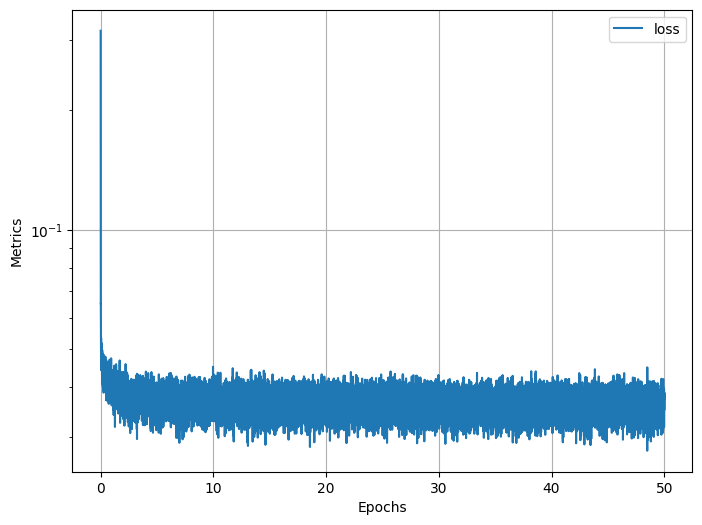

In [ ]:
report.plot(log=True)

101

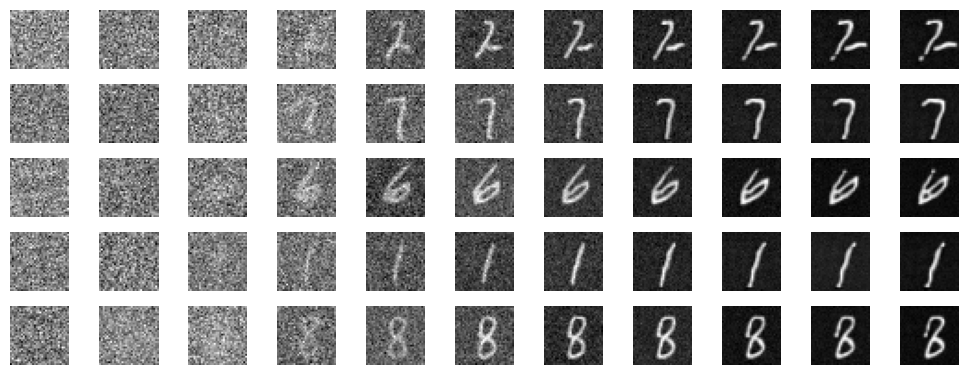

In [ ]:
net.cpu()
noise = torch.randn(5,1,32,32).to(net.device)
progress = [noise[:,0]]

for ts in np.logspace(np.log10(999), 0.1, 100):
  ts = torch.Tensor([ts]).long().to(net.device)
  noise = net(noise, ts).sample.detach().cpu()
  noise, _ = corrupt(noise, ts)
  progress.append(noise[:,0])

print(len(progress))
_n = 10
subplots(torch.stack(progress[::_n]).permute(1, 0, 2, 3).reshape(-1, 32, 32), nc=11, sz=(10,4))